In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as sit
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns
import pandas as pd
plt.rc("figure",figsize=(20,10))

Après un régime rapide, la dynamique lente est donnée par 

$$
S=S^*,\quad T=T^*,\quad {\displaystyle I^*=\frac{m T^*}{m+\beta k T^*}},$$
$$ I_i(\tau)= I^* z_i(\tau),\qquad {\displaystyle  I_{ij}(\tau)=k \frac{I^* T^*}{S^*} z_i(\tau) z_j(\tau)}$$
où ${\bf z}  (\tau)=(z_i(\tau))_i$ verifie $\sum_i z_i(\tau)= 1$ et
\begin{equation}
\frac{d}{d\tau} {\bf z}  = D{\bf z } \cdot\big( \mu (A^t- A) {\bf z}+A^t {\bf z} - ({{\bf z}}^t A {{\bf z}}) {\bf 1}\big)
\end{equation}
avec ${\bf 1}=(1,\cdots,1)^t$, $A=(\alpha_{ij})_{i,j}$ et les constantes
$$D=\frac{\beta T^* I^* (I\!I^*)^2}{2(T^*)^2-I^*I\!I^* }\qquad \text{et }\qquad \mu= \frac{I^*}{I\!I^*}.$$

Notons que $z_i$ peut être interprétée comme la poportion du strain $i$ dans le total de la maladie. 
La dynamique lente décrit donc simplement l'évolution lente de ces différentes proportions.

Si on note la fitness de l'espèce $i$ par rapport à l'espèce $j$ :
$$\lambda_i^j(\mu)=\mu (\alpha_{ji}-\alpha_{ij})+\alpha_{ji}-\alpha_{jj}$$
le système se réécrit
$$\frac{d}{d\tau} {\bf z_i}  = D{\bf z_i }\left(\sum_{j}\lambda_i^j{\bf z_j}-\sum_{k<j}( \lambda_k^j+\lambda_j^k) {\bf z_k z_j}\right):=f_i({\bf z}).$$
ou plus simplement
$$\frac{d}{d\tau} {\bf z_i}  = D{\bf z_i }\left(\sum_{j}\lambda_i^j{\bf z_j}-\sum_{k\, ,\,j} \lambda_j^k {\bf z_k z_j}\right):=f_i({\bf z}).$$
ce qui se réécrit de manière condensée
$$\frac{d}{d\tau} {\bf z}  = D{\bf z }\left(\Lambda {\bf z}-{\bf z}^T \Lambda \bf{z}\right)$$
où $\Lambda=(\lambda_i^k)_{i,k}$ est la matrice des fitness et la multiplication de deux vecteurs est comprise termes à termes.

In [6]:
#Parametres of  the neutral
N,m,kmean,R0= 3,6.,0.5,5.
beta=m*R0
#elements clefs du neutral model
Ss,Ts,Is=1/R0,1-1/R0,(R0-1)/(R0+R0*kmean*(R0-1))
IIs,IIijs=Ts-Is,kmean*Is*Ts /Ss
N=3;
A0=np.random.random((N,N))
A0[0,0]=-0.;A0[0,1]=-0.5;A0[0,2]=+0.5
A0[1,0]=-0.5;A0[1,1]=+0.1;A0[1,2]=+0.5
A0[2,0]=+0.6;A0[2,1]=-0.5;A0[2,2]=+0.
def slowdyn(z,t,mu=Is/IIs,D=1,A=-A0):
    Nonsym=np.dot(A-A.T,z)
    sym=np.dot(A,z)
    Q=np.dot(z.T,np.dot(A,z))
    return D*z*((mu*Nonsym+sym-Q))
def slowdynr(z,t,mu=Is/IIs,D=1,A=-A0):
    Nonsym=np.dot(A-A.T,z)
    sym=np.dot(A,z)
    Q=np.dot(z.T,np.dot(A,z))
    return -D*z*((mu*Nonsym+sym-Q))


A positive stationary steady state $E=(z_1,\cdots,z_n)$ satisfies the linear system

$$\begin{cases}
{\displaystyle \sum_{j=1}^n \mu (a_{ji}-a_{ij})z_j+a_{ji}z_j=\sum_{j=1}^n \mu (a_{ji+1}-a_{i+1j})z_j+a_{ji+1}z_j},\quad i=1,\cdots,n-1\\
z_1+\cdots+z_n=1\\
\end{cases}$$
which can be read shortly

$$\begin{cases}
{\displaystyle \sum_{j=1}^n \big((\mu+1) (a_{ji}-a_{ji+1})-\mu(a_{ij}-a_{i+1j})\big)z_j}=0,\quad i=1,\cdots,n-1\\
z_1+\cdots+z_n=1
\end{cases}$$

In [26]:
##On commence donc par calculer ces solutions
def steady_state(A,mu):
    n=len(A)
    mat=mu*(A.T-A)+A.T
    C=np.concatenate( (mat[0:n-1,:]-mat[1:n,:],np.ones((1,n))), axis=0)
    det=np.linalg.det(C)
    if det==0: 
        print('Encore du travail !')
        return None 
    b=np.zeros((n,1))
    b[n-1]=1
    Xsol=np.linalg.solve(C,b)
    if len(Xsol[Xsol<0])>=1:
        print('Pas de solution positive')
        return None
    else : 
        print('Solution de coexistence')
        return Xsol
#Version alternative avec les fitness.
#Fonction de calcul des fitness
def fitness(A,mu):
    n=len(A)
    return mu*(A.T-A)+A.T-np.ones((n,1))@np.reshape(np.diagonal(A),(1,n))
##Calcul des solutions avec la version fitness
def steady_state_fit(FIT):
    n=len(FIT)        
    C=np.concatenate( (np.ones((1,n)),(FIT[0:n-1,:]-FIT[1:n,:])), axis=0)
    det=np.linalg.det(C)
    if det==0: 
        #print('Encore du travail !')
        return 0
    b=np.zeros((n,1))
    b[0]=1
    Xsol=np.linalg.solve(C,b)
    if len(Xsol[Xsol<0])>=1:
        #print('Pas de solution positive')
        return 0
    else : 
        #print('Solution de coexistence')
        return Xsol

In [27]:
A,mu=np.random.random((3,3)),0.5
FIT=fitness(A,mu)
Xsol=steady_state(A,mu)
Xsolfit=steady_state_fit(FIT)
Xsol==Xsolfit

Pas de solution positive


False

In [ ]:
A=np.random.random((3,3))
B=np.zeros((4,4))
B[0,0]=2
B[1:,1:]=A
Q=np.concatenate((np.zeros((1,3)),np.eye(3)),axis=0)

print('B=', B ,'\nBreduc=', np.dot(np.dot((Q.T),B),Q ))

On a en tout $z=(z_i)_i\in\mathbb{R}^N$, 
$$\begin{cases}\partial_j  f_i(z)=z_i \left(\lambda_i^j- {\displaystyle\sum_{k\neq j} (\lambda_k^j +\lambda_j^k)z_k}\right)&\text{ si } j\neq i\\ 
z_i \left(\lambda_i^i- {\displaystyle\sum_{k\neq i} (\lambda_k^i +\lambda_i^k)z_k}\right)+{\displaystyle\left(\sum_{j}\lambda_i^j{ z_j}-\sum_k\sum_{j} \lambda_j^k { z_k z_j}\right)}&\text{ si }j=i\end{cases}.$$
La matrice jacobienne en une solution de coexistence $z^*=(z_k)_k$ est


$$Df_{z^*}=\begin{pmatrix} 
\displaystyle{z_1\left(\lambda_1^1-\sum_{k} (\lambda_k^1+\lambda_1^k) z_k\right)}& 
\displaystyle{z_1\left(\lambda_1^2-\sum_{k} (\lambda_k^2+\lambda_2^k) z_k\right)} & 
\cdots&
\displaystyle{z_1\left(\lambda_1^N-\sum_{k} (\lambda_k^N+\lambda_N^k) z_k\right)}\\
%
\vdots&\vdots & & \vdots  \\
\vdots&\vdots & & \vdots  \\
\displaystyle{z_N\left(\lambda_N^1-\sum_{k} (\lambda_k^1+\lambda_1^k) z_k\right)}& \displaystyle{z_N\left(\lambda_N^2-\sum_{k} (\lambda_k^2+\lambda_2^k) z_k\right)} & 
\cdots&
\displaystyle{z_N\left(\lambda_{N}^N-\sum_{k} (\lambda_k^N+\lambda_N^k) z_k\right)}
\end{pmatrix} $$
Soit en notant $\Lambda=(\lambda_i^j)_{i,j}$ :  la matrice des fitness
$$Df_{z^*}=diag(z^*)\cdot\left(\Lambda- 1_{N\times N}\cdot diag((\Lambda+\Lambda^T) \cdot z^*)\right).$$ 

si $z^*$ n'est pas une solution de coexistence, alors on doit ajouter la matrice diagonale
$$\begin{pmatrix}{\displaystyle\left(\sum_{j}\lambda_1^j{ z_j}-\sum_k\sum_{j} \lambda_j^k { z_k z_j}\right)}&&\\&\ddots&\\&&
{\displaystyle\left(\sum_{j}\lambda_N^j{ z_j}-\sum_k\sum_{j} \lambda_j^k { z_k z_j}\right)}
\end{pmatrix}$$
ce qui s'écrit simplement
$$diag(\Lambda\cdot z-z^T \Lambda z)$$
Au final, en tout $z$, on a 
$$Df_z=diag(z)\cdot\left(\Lambda- 1_{N\times N}\cdot diag((\Lambda+\Lambda^T) \cdot z)\right)+diag(\Lambda\cdot z-z^T \Lambda z)$$

In [8]:
def Jac(FIT,z):
    n=len(FIT)
    z=np.reshape(z,(n,1))
    JAC_coex=np.diag(z.T[0])@(FIT-np.ones((n,n))@np.diag(np.array((FIT+FIT.T)@z).T[0]))
    bloc=np.array((FIT)@z -((z.T)@FIT@z)).T[0]
    JAC_trivial=np.diag(bloc)
    return JAC_coex+JAC_trivial

In [9]:
FIT=2*np.random.random((3,3))-1
z=[1,0,0]
np.round(Jac_red(FIT,z),2)

[[ 1.  1.  1.]
 [ 1. -1. -0.]
 [ 1. -0. -1.]]


array([[-1.29,  0.  ],
       [ 0.  , -0.09]])

Comme nous ne sommes intéressés qu'a la restriction du système au simplexe $\sum z_i=1$ , $z_i\geq 0$, on sait que le vecteur $1$ est un vecteur propre à gauche de $Df$ et que l on se restreint à l'espace orthogonal à ce vecteur propre.

Notons $\mathcal{M}=M+c_0$ où $c_0=\frac{1}{N} (1,\cdots,1)$ et $M=1^\perp$ 
et définissons $g\;:\; \mathcal{M}\mapsto M$  la projection sur $M$ de la restriction de $f$ à $\mathcal{M}$. Dire que $\mathcal{M}$ est invariant sous le flot de $\dot{z}=f(z)$ équivaut à dire que $g(z)=f(z)\in M$ pour tout $z\in\mathcal{M}$. Le système réduit à $\mathcal{M}$ est donc $$\dot{z}=g(z).$$ 

L'étude de la stabilité linéaire d'une solution stationnaire passe donc naturellement par l'étude des valeurs propres de $Df_z$ réduite à $M$ c'est-à-dire par l'étude des valeurs propres de $Dg_z$. 
On déduit la  jacobienne de $g$ à partir de celle de $f$ via la relation:
$$Dg_z=P^{-1} Df_z P$$

où $P=\begin{pmatrix} 1&\cdots&1\\ &Q&\end{pmatrix}$ est la matrice d'une des bases  de $M$ :




In [34]:
def Jac_red(FIT,z): 
    n=len(FIT)
    s2,s3,s6=np.sqrt(2),np.sqrt(3),np.sqrt(6)
    P=np.concatenate( (np.ones((1,n)),
                       np.concatenate((np.ones((n-1,1)),
                                       -np.eye(n-1)),
                                      axis=1)),
                     axis=0)
    print(P)
    JAC=Jac(FIT,z)
    JACnew=np.linalg.inv(P)@JAC@P
    print(JACnew)
    return JACnew[1:,1:]
def stab(FIT,z):
    M=Jac_red(FIT,z)
    VP=np.linalg.eig(M)[0]
    U=-1
    for v in VP:
        if v>0: U=1
        if (v==0&U==-1):U=0
    return U
def stab_val(FIT,z):
    M=Jac_red(FIT,z)
    VP=np.linalg.eig(M)[0]
    return np.max(VP.real)
        
    

In [36]:
A=np.random.random((4,4))
FIT=fitness(A=A,mu=1)
z=[1,0,0]
Jac_red(FIT,z)

[[ 1.  1.  1.  1.]
 [ 1. -1. -0. -0.]
 [ 1. -0. -1. -0.]
 [ 1. -0. -0. -1.]]


ValueError: cannot reshape array of size 3 into shape (4,1)

In [37]:
A=2*np.eye(3)

In [40]:
L=np.linalg.eig(A)[0]


In [17]:
A=np.random.random((3,3))
A@A

array([[1.31245219, 0.87052662, 0.13408915],
       [0.80209325, 0.75779178, 0.13506707],
       [0.7592299 , 0.93717245, 0.93199914]])

In [9]:
A=np.random.random((3,3))
FIT=fitness(A,1)
z=[1,0,0]
print(FIT)
print(Jac(FIT,z))
print(Jac_red(FIT,z))

ValueError: shapes (3,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

In [10]:
A=np.random.random((3,3))
FIT=fitness(A,1)
z=steady_state_fit(FIT)
print(z)
if not isinstance(z,int):
    print(stab_val(FIT,z))

ValueError: shapes (3,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

In [11]:
A=np.random.random((2,2))
mu=1
z=[1,0]
FIT=fitness(A,mu)
print(FIT)
Jac(FIT,z)

ValueError: shapes (2,1) and (2,) not aligned: 1 (dim 1) != 2 (dim 0)

In [12]:
##Definition des sous ensembles sauf l'ensemble vide
def partiesliste(seq):
    p = []
    i, imax = 1, 2**len(seq)-1
    while i <= imax:
        s = []
        j, jmax = 0, len(seq)-1
        while j <= jmax:
            if (i>>j)&1 == 1:
                s.append(seq[j])
            j += 1
        p.append(s)
        i += 1 
    
    return p

In [13]:
##Calculs des solutions stationnaires et de leurs stabilités
def classification_test(A=0,mu=0,FIT=[]):
    if len(FIT)==0:
        FIT=fitness(A,mu)
    N=len(FIT)
    ZZ,UU,ZZtype=[],[],[]


    PI=partiesliste(range(N))
    
    for I in PI:
        FITsub=np.zeros((len(I),len(I)))
        for i in range(len(I)):
            for j in range(len(I)):
                FITsub[i,j]=FIT[I[i],I[j]]
        zsub=steady_state_fit(FITsub)
        if not(isinstance(zsub, int)):
            z=np.zeros((N,1))
            z[I]=zsub
            UU.append(stab(FIT,np.array(z)))
            ZZ.append(z.reshape(N).tolist())
            ZZtype.append(len(I))
    return UU,ZZ,ZZtype
        
##Calculs des solutions stationnaires et de leurs stabilités
def classification_test_bis(A=0,mu=0,FIT=[]):
    if len(FIT)==0:
        FIT=fitness(A,mu)
    N=len(FIT)
    ZZ,UU,ZZtype,ZZeigen=[],[],[],[]


    PI=partiesliste(range(N))
    
    for I in PI:
        FITsub=np.zeros((len(I),len(I)))
        for i in range(len(I)):
            for j in range(len(I)):
                FITsub[i,j]=FIT[I[i],I[j]]
        zsub=steady_state_fit(FITsub)
        if not(isinstance(zsub, int)):
            z=np.zeros((N,1))
            z[I]=zsub
            UU.append(stab(FIT,np.array(z)))
            ZZ.append(z.reshape(N).tolist())
            ZZtype.append(len(I))
            ZZeigen.append(stab_val(FIT,np.array(z)))
    return UU,ZZ,ZZtype,ZZeigen
        
    

In [14]:
B=np.ones((3,3))-np.eye(3)
Z_stability,Z_value,Z_type,Z_eigen=classification_test_bis(FIT=B)
print(Z_type,Z_eigen)

[1, 1, 2, 1, 2, 2, 3] [1.0, 1.0, 0.5, 1.0, 0.5, 0.50000000000000011, -0.33333333333333326]


In [15]:
A=np.random.random((3,3))
UU,B,C=classification_test(A,mu)
n=len(UU)
for x in range(n):
    print(B[x])
    stabornotstab='stable'*(UU[x]<0)+'unstable'*(UU[x]>0)+'degenerate'*(UU[x]==0)
    print(f'une solution de {C[x]}-coexistence', stabornotstab)
    
    

ValueError: shapes (3,1) and (3,) not aligned: 1 (dim 1) != 3 (dim 0)

In [16]:
number=10
A=2*np.random.random((number,number))-1
Z_stability,Z_value,Z_type,Z_eigen=classification_test_bis(FIT=A)
np.array(Z_eigen)[np.array(Z_stability)==-1]

array([-0.15404381, -0.05254249, -0.07224523])

NameError: name 'n' is not defined

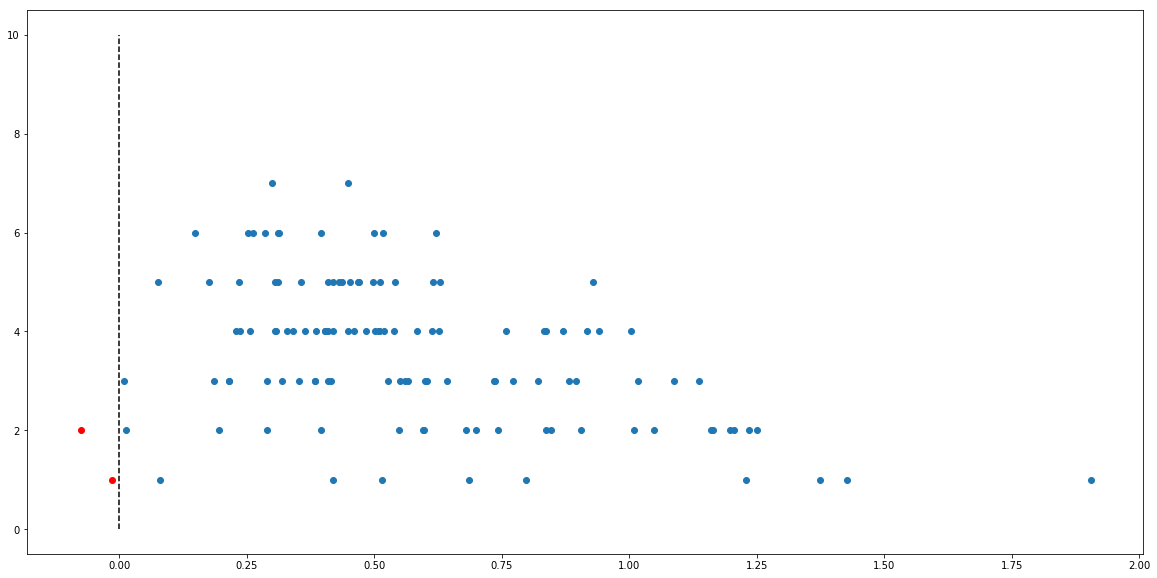

In [17]:
number=10
A=2*np.random.random((number,number))-1
Z_stability,Z_value,Z_type,Z_eigen=classification_test_bis(FIT=A)
Z_eigen_stable=np.array(Z_eigen)[np.array(Z_stability)==-1]
Z_eigen_unstable=np.array(Z_eigen)[np.array(Z_stability)==1]
Z_type_stable=np.array(Z_type)[np.array(Z_stability)==-1]
Z_type_unstable=np.array(Z_type)[np.array(Z_stability)==1]
ns=len(Z_type_stable)
nus=len(Z_type_unstable)
plt.scatter(Z_eigen_unstable,Z_type_unstable)
plt.scatter(Z_eigen_stable,Z_type_stable,color='red')
plt.plot([0,0],[0,number],'k--')
isarestable=' are '*(ns>1)+' is '*(ns<2)+'stable '
isareunstable=' are '*(nus>1)+' is '*(nus<2)+' unstable.'
titre='{} equilibria. {}'.format(n,ns)+isarestable+ 'and {}'.format(nus) +isareunstable
plt.title(titre)
plt.ylim([0,number]);

In [18]:
def entrop(z):
    if z==0: return 0
    return z*np.log(z)
def entropie(Z):
    E=[entrop(z) for z in Z]
    return -sum(E)

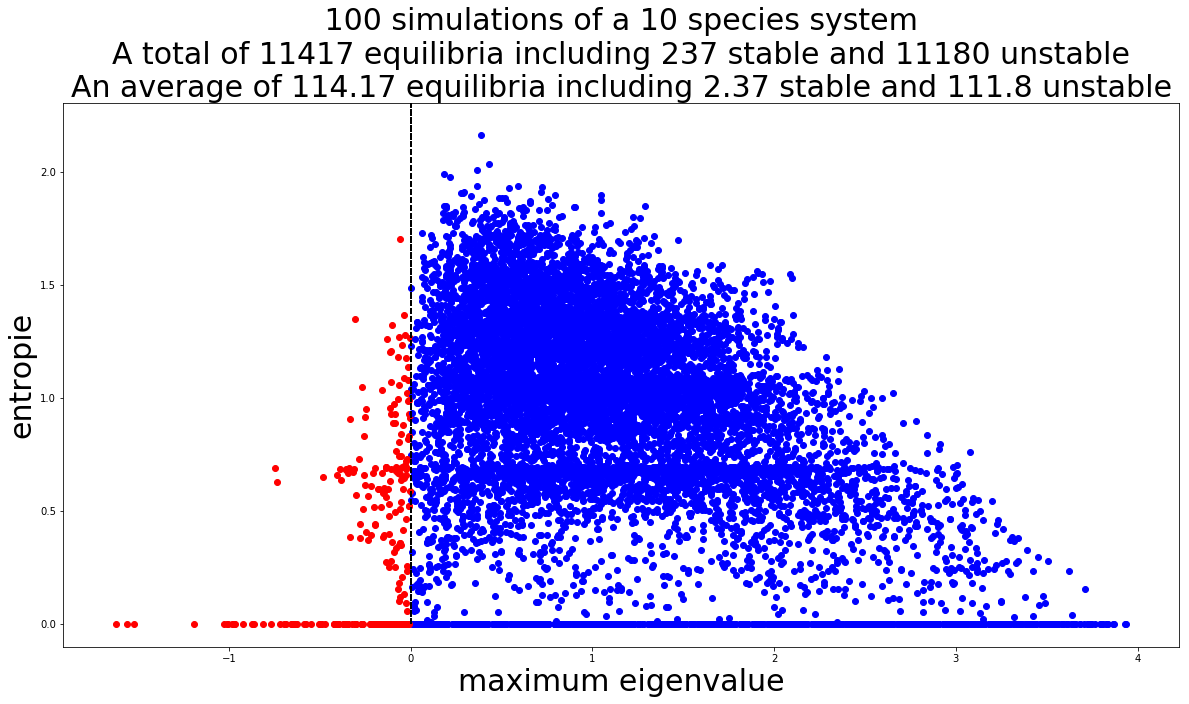

In [19]:
number=10
nsliste,nusliste,ntotliste=[],[],[]
it=100
for _ in range(it):
    A=4*np.random.random((number,number))-2
    Z_stability,Z_value,Z_type,Z_eigen=classification_test_bis(FIT=A)
    Z_entro=[entropie(z) for z in Z_value];
    Z_eigen_stable=np.array(Z_eigen)[np.array(Z_stability)==-1]
    Z_eigen_unstable=np.array(Z_eigen)[np.array(Z_stability)==1]
    Z_entro_stable=np.array(Z_entro)[np.array(Z_stability)==-1]
    Z_entro_unstable=np.array(Z_entro)[np.array(Z_stability)==1]
    nsliste.append(len(Z_eigen_stable))
    nusliste.append(len(Z_eigen_unstable))
    ntotliste.append(len(Z_eigen))
    plt.scatter(Z_eigen_unstable,Z_entro_unstable,color='blue')
    plt.scatter(Z_eigen_stable,Z_entro_stable,color='red')
    plt.plot([0,0],[0,np.log(number)],'k--')
ns,nus,n=sum(nsliste),sum(nusliste),sum(ntotliste) 
nsmean,nusmean,nmean=ns/it,nus/it,n/it

titre=' {} simulations of a {} species system \n'.format(it,number)
titretot= 'A total of {} equilibria including {} stable'.format(n,ns)+' and {} unstable'.format(nus) 
titremoy='An average of {} equilibria including {} stable'.format(nmean,nsmean)+' and {} unstable'.format(nusmean) 
plt.title(titre+titretot+'\n'+titremoy,size=30)
plt.ylabel('entropie',size=30)
plt.xlabel('maximum eigenvalue',size=30)
plt.ylim([-0.1,np.log(number)]);


In [28]:
def scatter_result(number=5,mu=[],k=0,var=1):##la fonction de calcul pour un tirage donnée
    if isinstance(mu,float)==1:
        A=np.random.normal(k,var,(number,number))-1
        A=A/np.sqrt(np.sum(A**2))
        FIT=[]
    else:
        A=0
        FIT=2*np.random.random((number,number))-1
    Z_stability,Z_value,Z_type,Z_eigen=classification_test_bis(A=A,mu=mu,FIT=FIT)
    Z_entro=[entropie(z) for z in Z_value];
    Z_eigen_stable=np.array(Z_eigen)[np.array(Z_stability)==-1]
    Z_eigen_unstable=np.array(Z_eigen)[np.array(Z_stability)==1]
    Z_entro_stable=np.array(Z_entro)[np.array(Z_stability)==-1]
    Z_entro_unstable=np.array(Z_entro)[np.array(Z_stability)==1]
    ns=len(Z_eigen_stable)
    nus=len(Z_eigen_unstable)
    ntot=len(Z_eigen)
    Zstable=Z_eigen_stable,Z_entro_stable,ns
    Zunstable=Z_eigen_unstable,Z_entro_unstable,nus
    return Zstable,Zunstable
def scatter_plot_one(number=5,mu=[]): ##la fonction de dessin pour un tirage donné
    Zstable,Zunstable=scatter_result(number=number,mu=mu)
    Z_eigen_stable,Z_entro_stable,ns=Zstable
    Z_eigen_unstable,Z_entro_unstable,nus=Zunstable
    n=nus+ns
    nmean,nsmean,nusmean=n/it,ns/it,nus/it
    plt.scatter(Z_eigen_unstable,Z_entro_unstable,color='blue')
    plt.scatter(Z_eigen_stable,Z_entro_stable,color='red')

    plt.ylabel('entropie',size=30)
    plt.xlabel('maximum eigenvalue',size=30)
    plt.ylim([-0.1,np.log(number)]);
    return ns,nus,n
def scatter_plot(number=5,it=10,mu=[]): #la fonction qui cumule les dessins.
    nstot,nustot,ntot=0,0,0
    for _ in range(it):
        ns,nus,n=scatter_plot_one(number=number,mu=mu)
        nstot+=ns
        nustot+=nus
        ntot+=n
    nmean,nsmean,nusmean=ntot/it,nstot/it,nustot/it
    titre=' {} simulations of a {} species system \n'.format(it,number)
    titretot= 'A total of {} equilibria including {} stable '.format(ntot,nstot)+'and {} unstable'.format(nustot) 
    titremoy='An average of {} equilibria including {} stable '.format(nmean,nsmean)+'and {} unstable'.format(nusmean) 
    plt.title(titre+titretot+'\n'+titremoy,size=30)

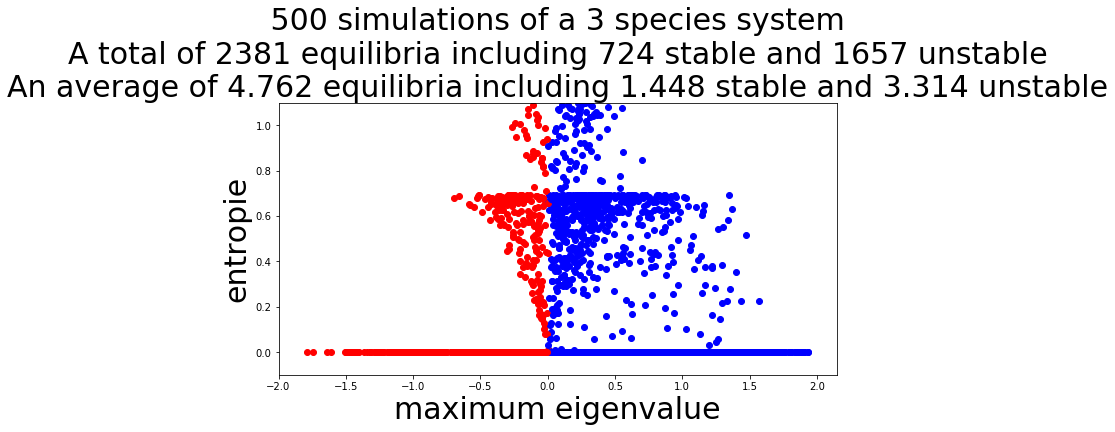

In [29]:
plt.rc("figure",figsize=(10,5))
for s in range(3,4):
    plt.figure()
    scatter_plot(number=s,it=500)

In [ ]:
plt.gca()

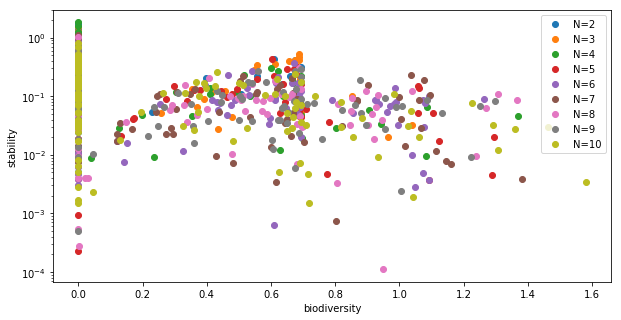

In [30]:
it =50
leg=[]
for number in range(2,11):
    biodiv,stable=[],[]
    for _ in range(it):
        Zstable,Zunstable=scatter_result(number=number)
        Z_eigen_stable,Z_entro_stable,ns=Zstable
        biodiv=biodiv+[z for z in Z_entro_stable]
        stable=stable+[np.abs(z) for z in Z_eigen_stable]
    plt.plot(biodiv,stable,'o')
    leg.append('N={}'.format(number))
plt.xlabel('biodiversity')
plt.ylabel('stability')
plt.yscale('log')
plt.legend(leg)
    

# Ce qui suit n'est pas terminé.

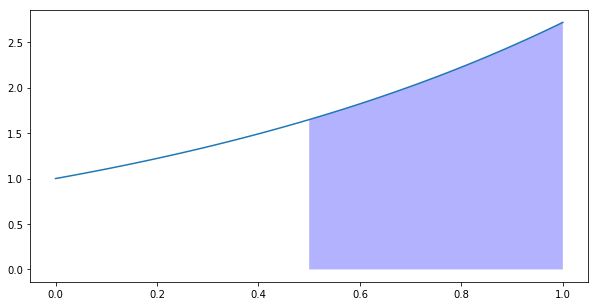

In [ ]:
fig=plt.figure()

for k in range(2,11):
    ax= fig.add_subplot(4,4 , k-1)
    nbsb=[]
    nbtot=[]
    nbuns=[]
    leg0,leg1='no stable stady state','1 stable steady state'
    legend=[]
    BILAN=[[]for i in range(2**k-1)]
    for _ in range(100):
        A=np.random.random((k,k))-0.5
        mu=10*np.random.random()
        UU,B,C=classification_test(A,mu)
        #print('\nTirage number', _)
        #for k in range(1,11):
            #UUk=np.array(UU)[np.array(C)==k]
            #print('il y a', len(np.array(C)[np.array(C)==k]), k,'-solution de coexistence dont',len(UUk[UUk<0]),'stable' )
        number_stable=len(np.array(UU)[np.array(UU)<0])
        #print(number_stable)
        if (number_stable==0) and (not(leg0 in legend)) : legend.append(leg0)
        if (number_stable==1) and (not(leg1 in legend)) : legend.append(leg1)
        if (number_stable>1) and (not(f'{number_stable} stable steady states' in legend)) : 
            legend.append(f'{number_stable} stable steady states')
        BILAN[number_stable-1].append(len(UU))
        #print(BILAN[number_stable-1])
        #print('BILAN=',BILAN)
    print('BILAN=',BILAN)
    print(legend)
    ax.hist(BILAN,histtype=  'barstacked',normed=1)
    ax.legend(legend)
    plt.title(f'Number of stable and unstable steady state  for N={k} strains')
plt.show()

In [ ]:
number_stable=2
legend=[]
print(f'there is {number_stable} stable steady states')
#legend_new in legend

In [16]:
fig=plt.figure()
itt=0
Nmax=10
BILAN=[]
titre_columns=['Nb of sp', 'Nb of ss','Nb of sss']

for k in range(1,Nmax+1):
    titre_columns.append(f'{k}-coexistence sss')
ncol=len(titre_columns)
dico_col={}
for k in range(ncol):
    dico_col.update({titre_columns[k]: titre_columns[k]})
for k in range(2,Nmax+1):
    for _ in range(100):
        summary=[0 for i in range(Nmax+3)]
        A=np.random.random((k,k))-0.5
        mu=10*np.random.random()
        UU,BB,CC=classification_test(A,mu)
        U=np.array(UU)
        B=np.array(BB)
        C=np.array(CC)
        nb_stable=len(U[U<0])
        for j in range(1,k+1):
            summary[2+j]=len((U[C==j])[(U[C==j]<0)==True])                            
        summary[0]=k
        summary[1]=len(U)
        summary[2]=nb_stable                       
        BILAN.append(summary)
df2 = pd.DataFrame(BILAN,columns=dico_col)                           


In [18]:
df2

,Nb of sp,Nb of ss,Nb of sss,1-coexistence sss,2-coexistence sss,3-coexistence sss,4-coexistence sss,5-coexistence sss,6-coexistence sss,7-coexistence sss,8-coexistence sss,9-coexistence sss,10-coexistence sss
0,2,2,1,1,0,0,0,0,0,0,0,0,0
1,2,2,1,1,0,0,0,0,0,0,0,0,0
2,2,3,2,2,0,0,0,0,0,0,0,0,0
3,2,2,1,1,0,0,0,0,0,0,0,0,0
4,2,2,1,1,0,0,0,0,0,0,0,0,0
5,2,2,1,1,0,0,0,0,0,0,0,0,0
6,2,3,2,2,0,0,0,0,0,0,0,0,0
7,2,2,1,1,0,0,0,0,0,0,0,0,0
8,2,2,1,1,0,0,0,0,0,0,0,0,0
9,2,2,1,1,0,0,0,0,0,0,0,0,0


In [31]:
k=2
mean=[0 for _ in range(df2.shape[0])]
mean_rescale=[0 for _ in range(df2.shape[0])]
for k in range(1,Nmax+1):
    mean+=df2[f'{k}-coexistence sss']*k
for j in range(df2.shape[0]):
    if mean[j]>0:
        mean_rescale[j]=mean[j]/df2['Nb of sss'][j]
df2['mean']=mean_rescale

df=pd.DataFrame(df2[['mean']],index=df2[df2.columns[0]])
df

,mean
Nb of sp,
2,1.0
2,1.0
2,1.0
2,1.0
2,1.0
2,1.0
2,1.0
2,1.0
2,1.0


0       2
1       2
2       2
3       2
4       2
5       2
6       2
7       2
8       2
9       2
10      2
11      2
12      2
13      2
14      2
15      2
16      2
17      2
18      2
19      2
20      2
21      2
22      2
23      2
24      2
25      2
26      2
27      2
28      2
29      2
       ..
870    10
871    10
872    10
873    10
874    10
875    10
876    10
877    10
878    10
879    10
880    10
881    10
882    10
883    10
884    10
885    10
886    10
887    10
888    10
889    10
890    10
891    10
892    10
893    10
894    10
895    10
896    10
897    10
898    10
899    10
Name: Nb of sp, Length: 900, dtype: int64

In [33]:
df.plot.pie( figsize=(8, 4))

ValueError: pie requires either y column or 'subplots=True'

In [38]:



k=4
def moyenne(k,itt=20):
    n,somme,sommesquare=0,0,0
    for _ in range(itt):
        A=np.random.random((k,k))-0.5
        mu=10*np.random.random()
        UU,B,C=classification_test(A,mu)
        TYPE_stable=np.array(C)[np.array(UU)<0]
        for ty in TYPE_stable :
            n+=1
            somme+=ty
            sommesquare+=ty**2
    if not(n==0):    
        m,s=somme/n,np.sqrt(sommesquare/n-(somme/n)**2)
    else : m,s=0,0
    return m,s

In [ ]:
MM,MMlow,MMhig=[], [],[]
for k in range(2,17):
    m,s=moyenne(k)
    MM.append(m)
    MMlow.append(m-2*s)
    MMhig.append(m+2*s)

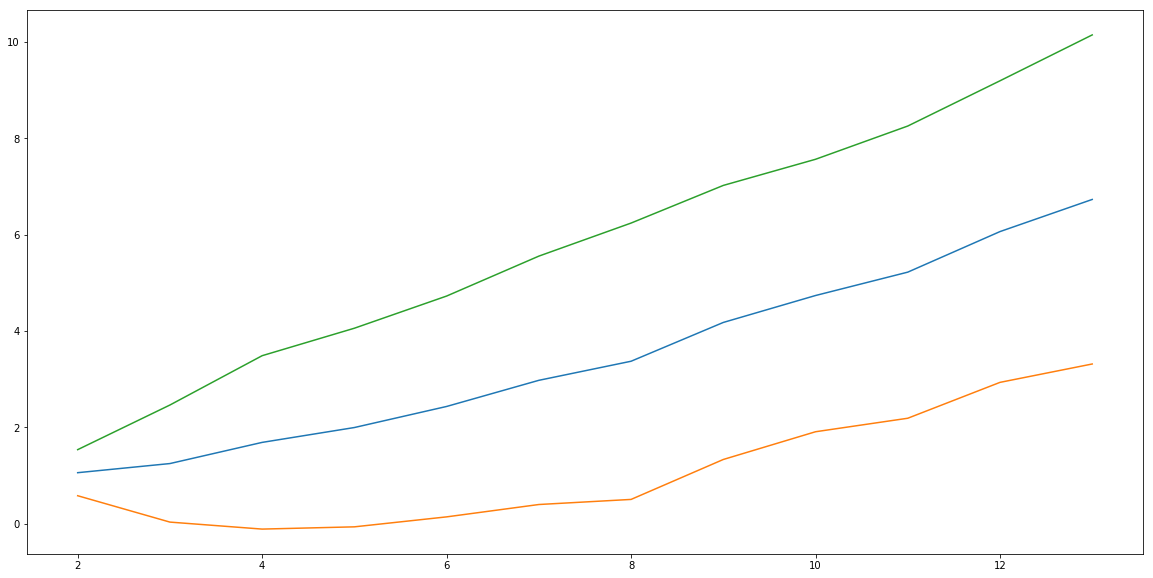

In [83]:
plt.plot(range(2,14),MM)
plt.plot(range(2,14),MMlow)
plt.plot(range(2,14),MMhig)

ValueError: Could not interpret input 'Nb of sp'

In [48]:
N=4
itt=100

df2 = pd.DataFrame(),
                   columns=titre_columns)
df2

,Nb of sp,Nb of ss,Nb of 1-coexistence stable ss,Nb of 2-coexistence stable ss,Nb of 3-coexistence stable ss,Nb of 4-coexistence stable ss,total Nb of stable ss
0,6,0,5,6,1,2,1
1,6,2,2,4,0,0,4
2,2,6,5,5,3,1,3
3,4,4,2,4,0,6,5
4,0,6,0,6,0,0,1
5,2,1,1,4,5,1,6
6,6,0,2,2,3,5,0
7,1,4,3,5,5,4,1
8,5,2,6,2,6,6,2
9,1,0,6,0,3,1,3


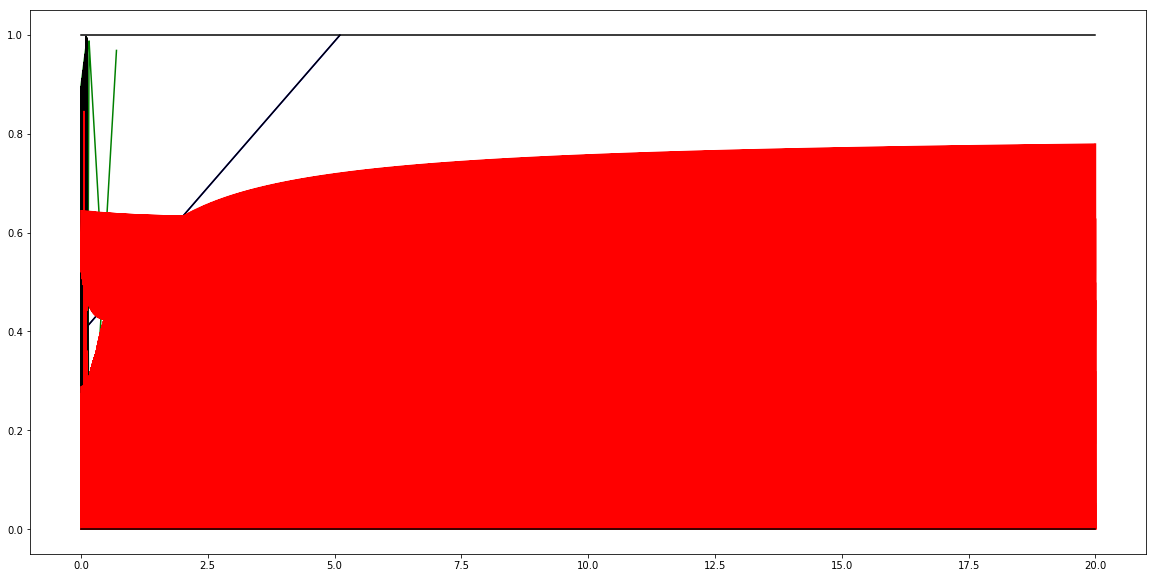

In [41]:
SOL12,SOL23,SOL13=[],[],[] 
MM12,MM23,MM13=[],[],[] 
SOL3,MM3=[],[]
mumax=20
for mu in np.linspace(0,mumax,1000):
    UU,B,C=classification_test(A,mu)
    Bn2=np.array(B)[np.array(C)==2]
    Bn3=np.array(B)[np.array(C)==3]
    if len(Bn2)>0:
        #print(Bnt)
        for x in Bn2:
            if x[0]==0: SOL23.append(x.tolist()),MM23.append(mu)
            if x[1]==0: SOL13.append(x.tolist()),MM13.append(mu)
            if x[2]==0: SOL12.append(x.tolist()),MM12.append(mu)
    if len(Bn3)>0:
        #print(Bnt)
        for x in Bn3:
            SOL3.append(x.tolist())
            MM3.append(mu)            
   # print(UU,B,C)
plt.plot(MM12,np.array(SOL12),'blue')  
plt.plot(MM13,np.array(SOL13),'green')
plt.plot(MM23,np.array(SOL23),'black')
plt.plot(MM3,np.array(SOL3),'red')
plt.plot([0,mumax],[1,1],'black')
plt.plot([0,mumax],[0,0],'black')

In [12]:
def affichage3sp(z_sol,ax1,couleur='red'):
    ##Definition et tracage du triangle
    theta ,droit= np.pi/6,np.pi/2
    X1 = np.array([np.cos(droit+4*theta), np.sin(droit+4*theta)])
    X2 = np.array([np.cos(-theta), np.sin(-theta)])
    X3 = np.array([np.cos(droit), np.sin(droit)])
    triangle=np.stack([X1,X2,X3,X1]).T
    ax1.axis('equal')
    ax1.axis("off")
    ax1.plot(*triangle,lw=2,color="black")
    X1pos=X1+[-0.2,0]
    X2pos=X2+[0.1,0]
    X3pos=X3+[-0.1,0.1]
    ax1.text(*X1pos, '$E_1$', size=20, zorder=1,  color='k')
    ax1.text(*X2pos, '$E_2$', size=20, zorder=1,  color='k')
    ax1.text(*X3pos, '$E_3$', size=20, zorder=1,  color='k')
    if len(z_sol)==0: 
        return None
    ##Projection des solutions forward et backward sur le triangle##
    x,y,z=z_sol.T
    taille = len(x)
    traj_x, traj_y = (X1.reshape(2,1) @ x.reshape(1,taille) 
                      + X2.reshape(2,1) @ y.reshape(1,taille) 
                      + X3.reshape(2,1) @ z.reshape(1,taille))


    ax1.plot(traj_x[-1],traj_y[-1],'o',color=couleur)

    
    #ax2.xaxis.set_ticklabels(fontsize = 'x-large') 

In [35]:
##Matrices avec cycles limites pour 4 especes##
def widgetNfit(B=np.eye(3),*args):
    N=   len(B)  
    fig=plt.figure(1)

    ax1 = plt.subplot2grid((1,1), (0, 0))#fig.add_subplot(1, 2, 1)
    if N==4 :
        if right_fig:
            ax1 = plt.subplot2grid((1,2), (0, 0),projection='3d')#fig.add_subplot(1, 2, 1,projection='3d')
            ax2 = plt.subplot2grid((3,2), (1, 1))
            fig.subplots_adjust(left = 0., 
                                bottom = 0.,
                                right = 0.5, 
                                top = 0.5, 
                                wspace = -0.0, hspace = 0)
            fig.text(0.22,0.37,title , size = 'x-large')
            #ax1.text(1,2.5,-13,title %mu, size = 'x-large')
        else:
            ax1 = plt.subplot2grid((1,1), (0, 0),projection='3d')#fig.add_subplot(1, 2, 1)
            ax2 = 1
            fig.suptitle(title , size = 25)
    Z_stability,Z_value,Z_type=classification_test(FIT=B)
    Zstab=np.array(Z_value)[np.array(Z_stability)<0]
    Zustab=np.array(Z_value)[np.array(Z_stability)>0]
    for z in Zstab:
        z_sol=np.array([z])
        affichage3sp(z_sol,ax1,couleur='red')
    for z in Zustab:
        z_sol=np.array([z])
        affichage3sp(z_sol,ax1,couleur='black')
    plt.show()
    return Z_stability,Z_value,Z_type

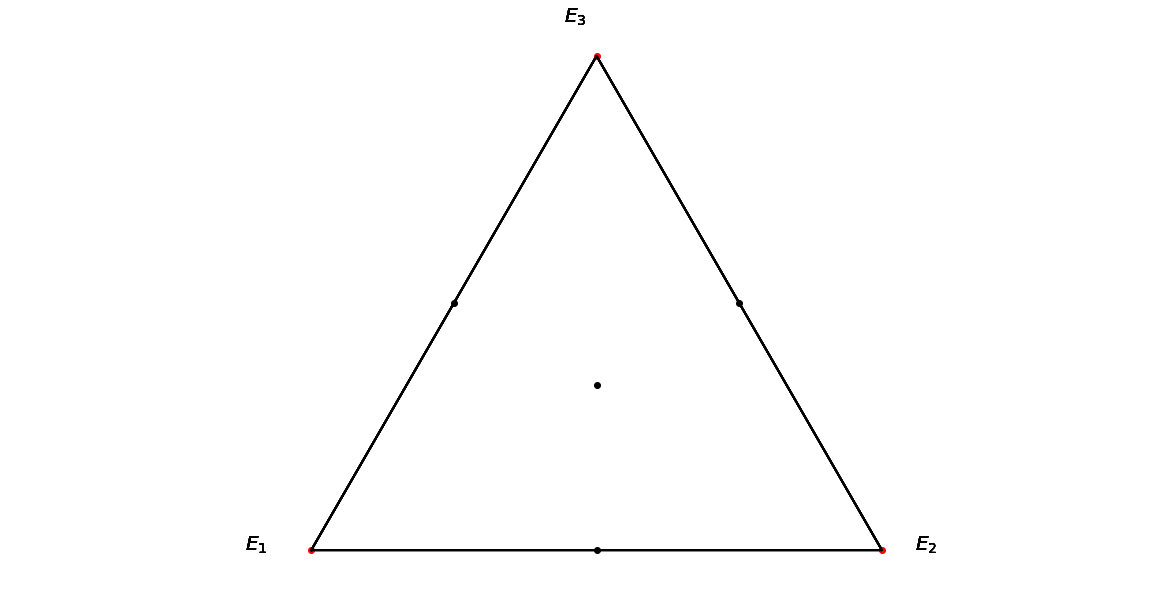

NameError: name 'tirage_dico' is not defined

In [37]:
c=widgetNfit(B=-np.ones((3,3))+np.eye(3))
wdgt=interactive(widgetNfit,mu=(0,10,0.1),
                 tmax=(0,10000,1000),
                 tirage=tirage_dico,
                view1=fixed(0),view2=fixed(0))
display(wdgt) 

In [15]:
def dessin_interactif(lambda12=-1,lambda21=-1,lambda13=-1,lambda31=-1,lambda23=-1,lambda32=-1):
    B=np.array([[0,lambda12,lambda13],[lambda21,0,lambda23],[lambda31,lambda32,0]])
    Z_stability,Z_value,Z_type=widgetNfit(B=B)
    return Z_stability,Z_value,Z_type
    
    

In [38]:
wdgt=interactive(dessin_interactif,
                 lambda12=(-1,1,0.1),lambda21=(-1,1,0.1),
                 lambda13=(-1,1,0.1),lambda31=(-1,1,0.1),
                 lambda23=(-1,1,0.1),lambda32=(-1,1,0.1))
display(wdgt) 

interactive(children=(FloatSlider(value=-1.0, description='lambda12', max=1.0, min=-1.0), FloatSlider(value=-1.0, description='lambda21', max=1.0, min=-1.0), FloatSlider(value=-1.0, description='lambda13', max=1.0, min=-1.0), FloatSlider(value=-1.0, description='lambda31', max=1.0, min=-1.0), FloatSlider(value=-1.0, description='lambda23', max=1.0, min=-1.0), FloatSlider(value=-1.0, description='lambda32', max=1.0, min=-1.0), Output()), _dom_classes=('widget-interact',))